# 0. Librerías

In [2]:
import keras
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.constraints import maxnorm
from sklearn.metrics import confusion_matrix
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cv2
import os
import PIL
import tensorflow as tf


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


## 0.1 Modelos

In [3]:
def Modelo_CN_Simple():
  model = Sequential()
  model.add( Dropout( 0.2,input_dim=1488 )                       )
  model.add(Dense( 128, activation='relu' ,  kernel_constraint=maxnorm(11)   ))
  model.add( Dropout( 0.2 ))
  model.add(Dense( 1024, activation='relu' ,  kernel_constraint=maxnorm(3)   ))
  model.add( Dropout( 0.2 ))
  model.add(Dense( 512, activation='relu' ,   kernel_constraint=maxnorm(3)    ))
  model.add(Dense( 256, activation='relu' ,   kernel_constraint=maxnorm(3)    ))
  model.add(Dense( 128, activation='relu' ,   kernel_constraint=maxnorm(3)    ))
  model.add(Dense( 64, activation='relu' ,   kernel_constraint=maxnorm(3)    ))
  model.add(Dense( num_classes, activation='sigmoid'     ))
  #Compilación
  model.compile( loss='categorical_crossentropy' , optimizer='RMSprop' , metrics=['accuracy'] )
  return model 

In [4]:
def modelo_CNN_Dropout():
    model = Sequential()
    model.add(Conv2D(128, (11,11), input_shape=(31, 48, 1), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (1,1), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(96, (1,1), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense( 512, activation='relu' ,  kernel_constraint=maxnorm(11)   ))
    model.add( Dropout( 0.2 ))
    model.add(Dense( 128, activation='relu' ,  kernel_constraint=maxnorm(11)   ))
    model.add(Dense( 64, activation='relu' ,  kernel_constraint=maxnorm(11)   ))

    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    return model

In [102]:
from keras.layers.normalization.batch_normalization import BatchNormalization
def model_CNN_Compleja():
    model = Sequential()
  #1488 
    model.add(Conv2D(128, (11,11), input_shape=(31, 48, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    

    model.add(Conv2D(512, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))


    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    model.summary()
    return model

## 0.2 Cargar google drive a google colab

In [5]:
# Load google drive to google colab
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


# 1. Red Neuronal Simple

## 1.1 Cargar datos

In [148]:
Train = '/content/MyDrive/MyDrive/Tesis/Tesis/datos_3cat/df_train_sinrotar_3cat.csv'
Test = '/content/MyDrive/MyDrive/Tesis/Tesis/datos_3cat/df_test_sinrotar_3cat.csv'

df_train=pd.read_csv(Train,header=None)
df_train=pd.concat([df_train[0],df_train.loc[:, 7:]], axis=1)

df_test=pd.read_csv(Test,header=None)
df_test=pd.concat([df_test[0],df_test.loc[:, 7:]], axis=1)

# Definir los conjuntos de datos de las muestras de entrenamiento y prueba
X_train=df_train.iloc[:,1:]
y_train=df_train.iloc[:,0]
y_train=y_train-1

X_test=df_test.iloc[:,1:]
y_test=df_test.iloc[:,0]
y_test=y_test-1

In [149]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [150]:
# one hot encode outputs
from keras.utils import np_utils

y_train = np_utils.to_categorical( y_train )
y_test = np_utils.to_categorical( y_test )

num_classes = y_test.shape[1]
num_classes

3

## 1.2 Aplicar el modelo

In [151]:
# build the model
model =Modelo_CN_Simple()

# Fit the model
history1 = model.fit(X_train_scaled,y_train,validation_data=(X_test_scaled,y_test), epochs=100, batch_size=32,  verbose=0,
                      steps_per_epoch=len(X_train_scaled) //32)

# 1m

In [152]:
# Final evaluation of the model
scores=model.evaluate(X_test_scaled,y_test,verbose=0)

print('Error del modelo base : %.2f%%' % (100-scores[1]*100))

Error del modelo base : 25.58%


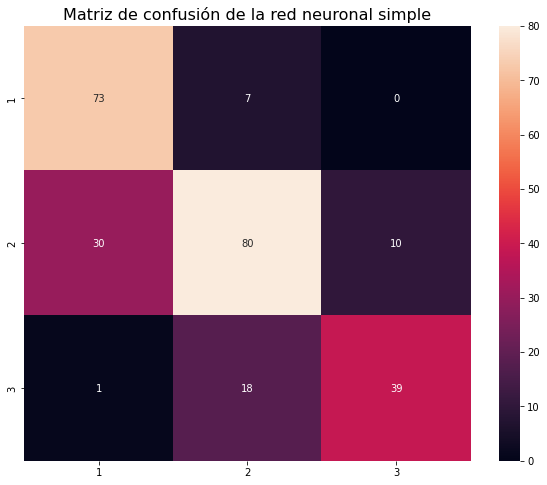

In [153]:
# Realizar predicciones con el modelo
y_predict = model.predict(X_test_scaled)

# Obtener la matriz de confusión del modelo  
y_test = np.argmax(y_test, axis=1)
y_predict = np.argmax(y_predict, axis=1)
cmatrix = confusion_matrix(y_test, y_predict)

# Graficar la matriz de confusión en un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(cmatrix, annot=True)
plt.title('Matriz de confusión de la red neuronal simple', fontsize=16)
plt.xticks([0.5, 1.5, 2.5], ['1', '2', '3'])
plt.yticks([0.5, 1.5, 2.5], ['1', '2', '3'])
plt.show()

# 2. Red Neuronal Convolucional

## 2.1 Crear el dataframe

In [123]:
# Seleccionar el directorio de trabajo
os.chdir('/content/MyDrive/MyDrive/Tesis')

In [124]:
data_dir='/content/MyDrive/MyDrive/Tesis/Tesis/muestras'

In [125]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/MyDrive/MyDrive/Tesis/Tesis/muestras')

In [126]:
primera_train=list(data_dir.glob('Primera/Training/*'))
segunda_train= list(data_dir.glob('Segunda/Training/*'))
tercera_train= list(data_dir.glob('Tercera/Training/*'))

primera_test=list(data_dir.glob('Primera/Test/*'))
segunda_test= list(data_dir.glob('Segunda/Test/*'))
tercera_test= list(data_dir.glob('Tercera/Test/*'))

In [127]:
train_images_dict = {
    'Primera' : primera_train,
    'Segunda' : segunda_train,
    'Tercera' : tercera_train
}


train_labels_dict = {
    'Primera': 0,
    'Segunda': 1,
    'Tercera': 2
}

In [128]:
test_images_dict = {
    'Primera' : primera_test,
    'Segunda' : segunda_test,
    'Tercera' : tercera_test
}


test_labels_dict = {
    'Primera': 0,
    'Segunda': 1,
    'Tercera': 2
}

In [129]:
X_train, y_train = [], []

for clasificacion, images in train_images_dict.items():
    print(clasificacion)
    for image in images:
        img = cv2.imread(str(image))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized_img = cv2.resize(img_gray,(48,31))
        X_train.append(resized_img)
        y_train.append(train_labels_dict[clasificacion])

Primera
Segunda
Tercera


In [130]:
X_test, y_test = [], []

for clasificacion2, images2 in test_images_dict.items():
    print(clasificacion2)
    for image in images2:
        img = cv2.imread(str(image))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized_img = cv2.resize(img_gray,(48,31))
        X_test.append(resized_img)
        y_test.append(test_labels_dict[clasificacion2])

Primera
Segunda
Tercera


In [131]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [132]:
X_train_scaled.shape

(2339, 31, 48)

In [133]:
X_test_scaled.shape

(258, 31, 48)

In [134]:
# one hot encode outputs
from keras.utils import np_utils

y_train = np_utils.to_categorical( y_train )
y_test = np_utils.to_categorical( y_test )

In [135]:
y_train.shape

(2339, 3)

In [136]:
y_test.shape

(258, 3)

In [137]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [138]:
num_classes = y_test.shape[1]
num_classes

3

## 2.2 Aplicar el modelo


In [141]:
# build the model
model =modelo_CNN_Dropout()

# Fit the model
history2 = model.fit(X_train_scaled,y_train,validation_data=(X_test_scaled,y_test), epochs=100, batch_size=32,  verbose=0,
                      steps_per_epoch=len(X_train_scaled) //32)

#1m

In [142]:
# Final evaluation of the model
scores=model.evaluate(X_test_scaled,y_test,verbose=0)

print('Error del modelo base : %.2f%%' % (100-scores[1]*100))

Error del modelo base : 22.48%


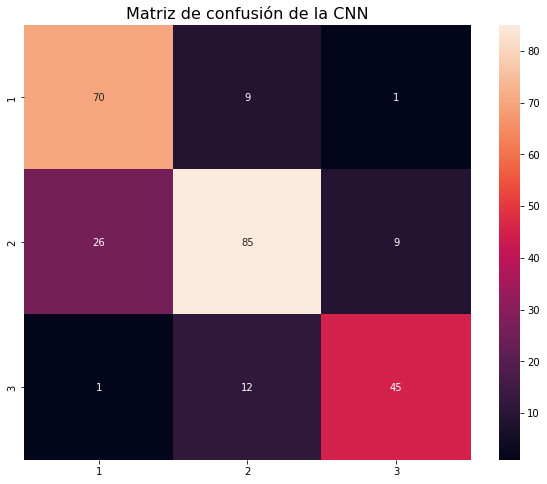

In [143]:
# Realizar predicciones con el modelo
y_predict = model.predict(X_test_scaled)

# Obtener la matriz de confusión del modelo  
y_test2 = np.argmax(y_test, axis=1)
y_predict2 = np.argmax(y_predict, axis=1)
cmatrix2 = confusion_matrix(y_test2, y_predict2)

# Graficar la matriz de confusión en un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(cmatrix2, annot=True)
plt.title('Matriz de confusión de la CNN', fontsize=16)
plt.xticks([0.5, 1.5, 2.5], ['1', '2', '3'])
plt.yticks([0.5, 1.5, 2.5], ['1', '2', '3'])
plt.show()

# 3. CNN Compleja

In [144]:
# build the model
model =model_CNN_Compleja()

# Fit the model
history3 = model.fit(X_train_scaled,y_train,validation_data=(X_test_scaled,y_test), epochs=100, batch_size=32,  verbose=0,
                      steps_per_epoch=len(X_train_scaled) //32)

#3m

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 21, 38, 128)       15616     
                                                                 
 batch_normalization_23 (Bat  (None, 21, 38, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 10, 19, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 8, 17, 512)        590336    
                                                                 
 batch_normalization_24 (Bat  (None, 8, 17, 512)       2048      
 chNormalization)                                                
                                                     

In [145]:
# Final evaluation of the model
scores=model.evaluate(X_test_scaled,y_test,verbose=0)

print('Error del modelo base : %.2f%%' % (100-scores[1]*100))

Error del modelo base : 23.26%


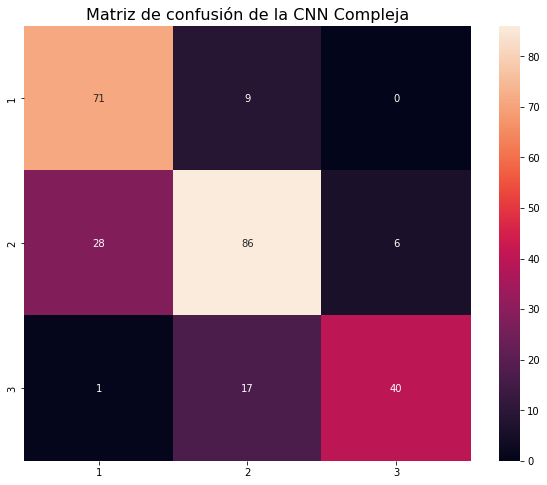

In [146]:
# Realizar predicciones con el modelo
y_predict = model.predict(X_test_scaled)

# Obtener la matriz de confusión del modelo  
y_test3 = np.argmax(y_test, axis=1)
y_predict3 = np.argmax(y_predict, axis=1)
cmatrix3 = confusion_matrix(y_test3, y_predict3)

# Graficar la matriz de confusión en un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(cmatrix3, annot=True)
plt.title('Matriz de confusión de la CNN Compleja', fontsize=16)
plt.xticks([0.5, 1.5, 2.5], ['1', '2', '3'])
plt.yticks([0.5, 1.5, 2.5], ['1', '2', '3'])
plt.show()

Text(0.5, 0.93, 'Precisión y pérdida de los modelos')

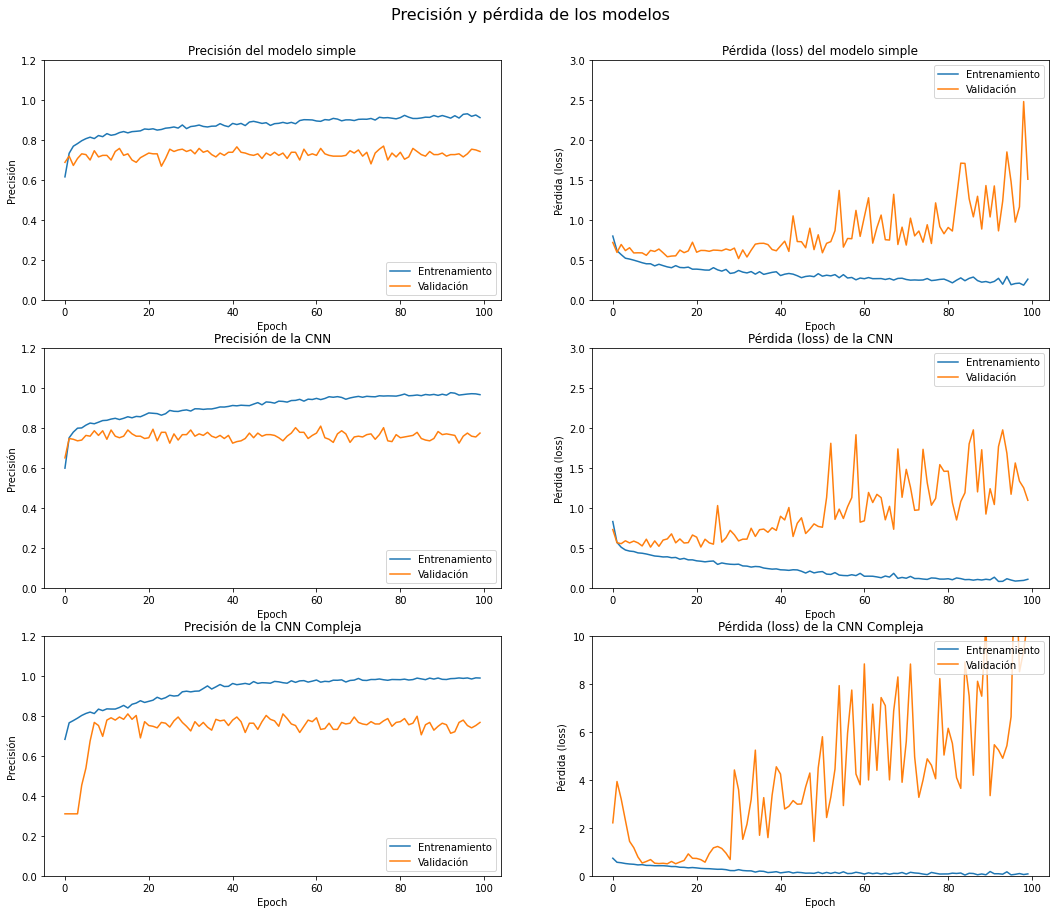

In [154]:
plt.figure(figsize=(18,15))
plt.subplot(3,2,1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.ylim(0, 1.2)
plt.title('Precisión del modelo simple')
plt.ylabel('Precisión')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
plt.subplot(3,2,2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Pérdida (loss) del modelo simple')
plt.ylabel('Pérdida (loss)')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.ylim([0,3])


plt.subplot(3,2,3)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylim(0, 1.2)
plt.title('Precisión de la CNN')
plt.ylabel('Precisión')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
plt.subplot(3,2,4)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Pérdida (loss) de la CNN')
plt.ylabel('Pérdida (loss)')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.ylim([0,3])

plt.subplot(3,2,5)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylim(0, 1.2)
plt.title('Precisión de la CNN Compleja')
plt.ylabel('Precisión')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
plt.subplot(3,2,6)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Pérdida (loss) de la CNN Compleja')
plt.ylabel('Pérdida (loss)')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.ylim([0,10])

plt.suptitle("Precisión y pérdida de los modelos",fontsize=16, y=0.93 )